# Portfolio optimization using Monte Carlo Simulation with Correlated Geometric Brownian Motion

We model the stock prices of multiple assets under the **Geometric Brownian Motion (GBM)** framework.

---

## 1. Returns and Parameters

For asset $ i $, let the price series be $ S_{i,t} $.  
The return is

$
r_{i,t} = \frac{S_{i,t}}{S_{i,t-1}} - 1
$

We estimate:

- Mean return:
$
\mu_i = \frac{1}{T-1} \sum_{t=1}^{T-1} r_{i,t}
$

- Volatility:
$
\sigma_i = \sqrt{\frac{1}{T-2} \sum_{t=1}^{T-1} (r_{i,t} - \mu_i)^2}
$

Stacked into vectors:

$
\boldsymbol{\mu} =
\begin{bmatrix}
\mu_1 \\ \mu_2 \\ \vdots \\ \mu_n
\end{bmatrix},
\quad
\boldsymbol{\sigma} =
\begin{bmatrix}
\sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_n
\end{bmatrix}
$

---

## 2. Correlation and Cholesky

Construct the sample **correlation matrix** of returns:

$
\mathbf{C} = \big[ \rho_{ij} \big]_{i,j=1}^n
$

where

$
\rho_{ij} = \frac{\text{Cov}(r_i, r_j)}{\sigma_i \sigma_j}
$

Then compute the **Cholesky decomposition**:

$
\mathbf{C} = \mathbf{L} \mathbf{L}^\top
$

with $\mathbf{L}$ lower-triangular.

---

## 3. Simulated Brownian Increments

Generate i.i.d. standard normal vectors:

$
\mathbf{Z}_t \sim \mathcal{N}(0, \mathbf{I}_n), \quad t = 1, \dots, T
$

Apply correlation structure:

$
\mathbf{W}_t = \mathbf{L} \mathbf{Z}_t
$

Thus, $\mathbf{W}_t \sim \mathcal{N}(0, \mathbf{C})$.

---

## 4. Geometric Brownian Motion (GBM)

For each asset $ i $:

$
S_{i,t} = S_{i,0} \cdot \exp \Bigg( \Big(\mu_i - \tfrac{1}{2}\sigma_i^2\Big)t \;+\; \sigma_i W_{i,t} \Bigg)
$

In vector form:

$
\mathbf{S}_t = \mathbf{S}_0 \odot \exp \Bigg( 
\big(\boldsymbol{\mu} - \tfrac{1}{2}\boldsymbol{\sigma}^2\big) t \;+\; \boldsymbol{\sigma} \odot \mathbf{W}_t
\Bigg)
$

where:
- $ \odot $ denotes elementwise multiplication,
- $ \boldsymbol{\sigma}^2 = (\sigma_1^2, \dots, \sigma_n^2)^\top $,
- $ \exp $ is applied elementwise.

---

## 5. Monte Carlo Replications

Repeat the above for $ N $ independent simulations:

$
\mathbf{S}_t^{(k)}, \quad k = 1, \dots, N
$

This yields a **3D object**:

$
\text{Simulations: } \quad \mathbb{R}^{N \times T \times n}
$

- $ N $: number of paths  
- $ T $: time steps  
- $ n $: number of assets  

---


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


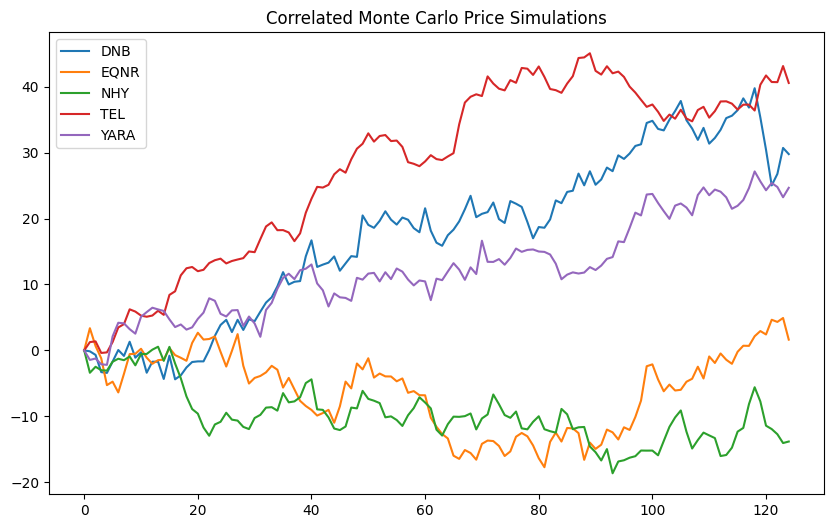

In [3]:
# --- Parameters ---
T = 125     # time steps
N = 50      # number of simulations per stock

# --- Load dataset ---
df = pd.read_csv("OSEBX_Q1Q2_with_indicators.csv", sep=";")

# --- Unique tickers ---
tickers = df["Ticker"].unique()
n_assets = len(tickers)

# --- Estimate parameters ---
mu_dict, sigma_dict = {}, {}
returns_df = pd.DataFrame()

for ticker in tickers:
    df_t = df[df["Ticker"] == ticker].reset_index(drop=True)
    S = df_t['Close'].astype(float)
    
    # returns
    S_lag = S[:-1].reset_index(drop=True)
    S_curr = S[1:].reset_index(drop=True)
    dS = np.array(S_curr) / np.array(S_lag) - 1
    
    # store mean and vol
    mu_dict[ticker] = np.mean(dS)
    sigma_dict[ticker] = np.std(dS, ddof=1)
    
    # collect returns for correlation
    returns_df[ticker] = dS

# --- Correlation & Cholesky ---
corr = returns_df.corr().values
L = np.linalg.cholesky(corr)   # lower triangular

# --- Monte Carlo simulations with correlation ---
simulations = {}

for t_idx, ticker in enumerate(tickers):
    S0 = df[df["Ticker"] == ticker]['Close'].iloc[0]
    simulations[ticker] = np.zeros((N, T))
    simulations[ticker][:, 0] = S0

# simulate paths jointly
for i in range(N):
    # correlated random shocks for all assets
    Z = np.random.normal(size=(T-1, n_assets))
    correlated_Z = np.inner(Z, L.T)  # apply Cholesky
    
    for t in range(1, T):
        for j, ticker in enumerate(tickers):
            mu = mu_dict[ticker]
            sigma = sigma_dict[ticker]
            S0 = simulations[ticker][i, t-1]
            
            drift = (mu - 0.5 * sigma**2)
            shock = sigma * correlated_Z[t-1, j]
            
            simulations[ticker][i, t] = S0 * np.exp(drift + shock)

# --- Plot example paths ---
plt.figure(figsize=(10,6))
for ticker in tickers:
    plt.plot(range(T), 100*(simulations[ticker][0]/simulations[ticker][0][0] - 1), label=ticker)  # first path of each stock
plt.legend()
plt.title("Correlated Monte Carlo Price Simulations")
plt.show()


# Portfolio Optimization Based on Simulated μ/σ Ratios

We use Monte Carlo simulations of stock prices to inform a simple **risk-adjusted selection strategy**.

---

## 1. Simulated Price Paths

Each stock $i$ has a set of Monte Carlo simulations $S_{i,t}^{(k)}$ for time steps $t = 0, \dots, T-1$ and simulation rounds $k = 1, \dots, N$:

$
S_{i,t}^{(k)} = S_{i,0} \exp \Big( (\mu_i - \tfrac{1}{2}\sigma_i^2) t + \sigma_i W_{i,t}^{(k)} \Big)
$

where:
- $\mu_i$ is the estimated daily drift of stock $i$,
- $\sigma_i$ is the estimated daily volatility of stock $i$,
- $W_{i,t}^{(k)}$ is the Brownian motion (or cumulative normal shocks) for simulation $k$.

---

## 2. Pathwise Returns

For each simulation $k$ and stock $i$, compute discrete returns along the simulated path:

$
r_{i,t}^{(k)} = \frac{S_{i,t}^{(k)} - S_{i,t-1}^{(k)}}{S_{i,t-1}^{(k)}}, \quad t = 1, \dots, T-1
$

Then compute the **mean** and **standard deviation** of returns for this path:

$
\hat{\mu}_i^{(k)} = \frac{1}{T-1} \sum_{t=1}^{T-1} r_{i,t}^{(k)}, 
\quad
\hat{\sigma}_i^{(k)} = \sqrt{ \frac{1}{T-2} \sum_{t=1}^{T-1} \big(r_{i,t}^{(k)} - \hat{\mu}_i^{(k)}\big)^2 }
$

---

## 3. Risk-Adjusted Performance Metric

Define the **risk-adjusted ratio** for each stock in each simulation:

$
R_i^{(k)} = \frac{\hat{\mu}_i^{(k)}}{\hat{\sigma}_i^{(k)}}
$

This is essentially a **Sharpe-like ratio** without subtracting the risk-free rate.

---

## 4. Optimal Stock Selection Per Simulation

For each Monte Carlo round $k$, select the stock with the highest risk-adjusted ratio:

$
i^*_{(k)} = \arg \max_i R_i^{(k)}
$

Count how often each stock is selected across all $N$ simulations:

$
f_i = \frac{1}{N} \sum_{k=1}^{N} \mathbf{1}\{ i^*_{(k)} = i \}
$

where $\mathbf{1}\{\cdot\}$ is the indicator function.

---

## 5. Portfolio Composition

The vector of frequencies

$
\mathbf{f} = [f_1, f_2, \dots, f_n]
$

represents a **simple optimal portfolio composition**:

- Each component $f_i$ is the proportion of simulations in which stock $i$ was the best risk-adjusted performer.
- The sum of all components is 1:

$
\sum_{i=1}^{n} f_i = 1
$

This can be visualized as a **pie chart** or bar chart showing relative preference for each stock.

---

### Summary

- Step 1: Simulate correlated or independent price paths for each stock.  
- Step 2: Compute pathwise returns and their mean/volatility.  
- Step 3: Calculate risk-adjusted ratios ($\mu/\sigma$) for each simulation.  
- Step 4: Pick the best-performing stock per simulation.  
- Step 5: Aggregate counts to construct a simple **probability-weighted portfolio**.


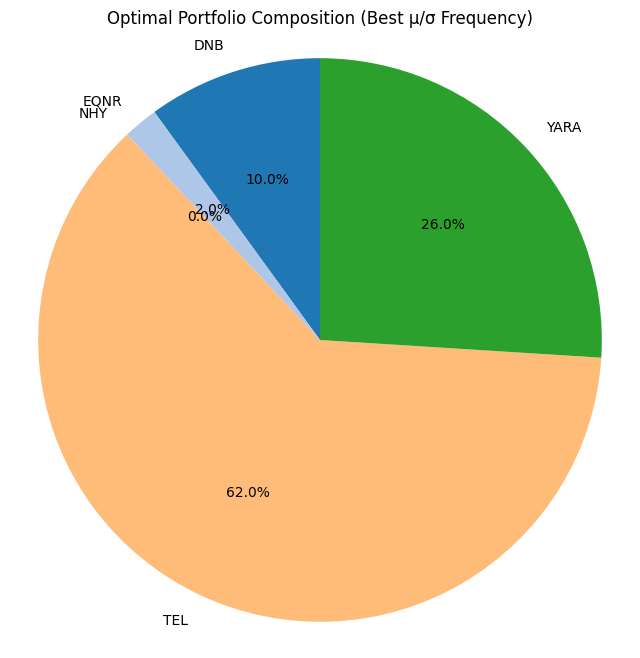

In [4]:
best_counts = {ticker: 0 for ticker in tickers}

for sim_round in range(N):
    ratios = {}
    for ticker in tickers:
        path = simulations[ticker][sim_round]
        
        # compute returns for this path
        returns = np.diff(path) / path[:-1]
        mu_path = np.mean(returns)
        sigma_path = np.std(returns, ddof=1)
        
        # avoid division by zero
        if sigma_path > 0:
            ratios[ticker] = mu_path / sigma_path
        else:
            ratios[ticker] = -np.inf
    
    # pick best ticker
    best_ticker = max(ratios, key=ratios.get)
    best_counts[best_ticker] += 1

# --- Convert results to portfolio composition ---
portfolio = pd.Series(best_counts) / N

# --- Plot composition as pie chart ---
plt.figure(figsize=(8,8))
plt.pie(portfolio, labels=portfolio.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title("Optimal Portfolio Composition (Best μ/σ Frequency)")
plt.axis('equal')  # ensures pie is circular
plt.show()

## Butterfly Spread with Calls

We want to construct a payoff that is positive when the terminal stock price $S_T$ is between two strike prices, and zero otherwise.

---

### 1. Payoff Function

We target the following payoff structure:

#
h(S_T) = 
\begin{cases}
0, & S_T < 80 \\
S_T - 80, & 80 \leq S_T < 100 \\
120 - S_T, & 100 \leq S_T < 120 \\
0, & S_T \geq 120
\end{cases}
#

This produces a **tent-shaped payoff** centered around $K=100$.

---

### 2. Portfolio Construction

We achieve this payoff using calls:

- **Buy 1 call** with strike $K_1 = 80$
- **Sell 2 calls** with strike $K_2 = 100$
- **Buy 1 call** with strike $K_3 = 120$

---

### 3. Payoff by Region

#### Case 1: $S_T < 80$
- All calls expire worthless.  
#
h(S_T) = 0
#

#### Case 2: $80 \leq S_T < 100$
- Call at 80 pays: $S_T - 80$
- Other calls are worthless.
#
h(S_T) = S_T - 80
#

#### Case 3: $100 \leq S_T < 120$
- Call at 80 pays: $S_T - 80$
- Two short calls at 100 cost: $-2(S_T - 100)$
- Call at 120 is worthless.
#
h(S_T) = (S_T - 80) - 2(S_T - 100) = 120 - S_T
#

#### Case 4: $S_T \geq 120$
- Call at 80 pays: $S_T - 80$
- Two short calls at 100 cost: $-2(S_T - 100)$
- Call at 120 pays: $S_T - 120$
#
h(S_T) = (S_T - 80) - 2(S_T - 100) + (S_T - 120) = 0
#

---

### 4. Portfolio Value at Time Zero

Let $C_0(K)$ denote the price of a European call option with strike $K$ at time 0.  
The value of the butterfly is:

#
V_0 = C_0(80) - 2C_0(100) + C_0(120)
#

---

### 5. Interpretation

- The payoff is **bounded above by 20** (the width of the strikes).  
- The maximum payoff occurs at $S_T = 100$.  
- The cost $V_0$ is typically small, so this strategy is often used to speculate on **low volatility** or to **hedge around a price target**.


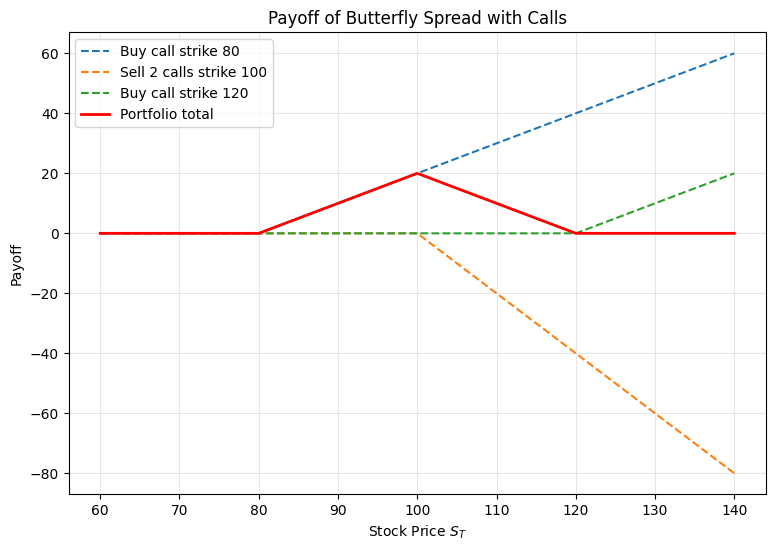

In [5]:
K1, K2, K3 = 80, 100, 120
S_T = np.linspace(60, 140, 500)

call1 = np.maximum(S_T - K1, 0)      # long call at 80
call2 = -2 * np.maximum(S_T - K2, 0) # short 2 calls at 100
call3 = np.maximum(S_T - K3, 0)      # long call at 120

portfolio = call1 + call2 + call3

# --- Plot ---
plt.figure(figsize=(9,6))
plt.plot(S_T, call1, label='Buy call strike 80', linestyle='--')
plt.plot(S_T, call2, label='Sell 2 calls strike 100', linestyle='--')
plt.plot(S_T, call3, label='Buy call strike 120', linestyle='--')
plt.plot(S_T, portfolio, label='Portfolio total', color='red', linewidth=2)

plt.title("Payoff of Butterfly Spread with Calls")
plt.xlabel("Stock Price $S_T$")
plt.ylabel("Payoff")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Volatility-Mispricing Hedge — Short Straddle + Daily Delta-Hedge

## Idea (verbal)
If the market prices options with an implied volatility $\sigma_{\text{imp}}$ that is larger than the true/realized volatility $\sigma_{\text{real}}$ we expect, then selling options at $\sigma_{\text{imp}}$ and dynamically hedging the short option exposure can make money on average. The intuition: we collect an **overpriced premium**, then offset directional risk by delta-hedging; if realized price movements are smaller than implied, hedging costs are low and the initial premium nets a profit.

We implement this with a **short straddle** (sell 1 call + sell 1 put) at strike $K$, hedge daily using deltas computed from Black–Scholes with $\sigma_{\text{imp}}$, but the underlying actually evolves with volatility $\sigma_{\text{real}}$.

---

## Notation and setup

- $S_t$ : underlying price at time $t$ ($t=0,\Delta t, 2\Delta t,\dots,T$).  
- $\Delta t$ : time-step (in years).  
- $r$ : continuously compounded risk-free rate.  
- $K$ : strike of call and put (ATM).  
- $\sigma_{\text{imp}}$ : implied volatility — used to price options and compute deltas.  
- $\sigma_{\text{real}}$ : true volatility used to simulate $S_t$.  
- $C(S,t;\sigma_{\text{imp}})$, $P(S,t;\sigma_{\text{imp}})$ : Black–Scholes call and put prices using $\sigma_{\text{imp}}$.  
- $\Delta_C(S,t)$, $\Delta_P(S,t)$ : option deltas (call delta $=\Phi(d_1)$, put delta $=\Phi(d_1)-1$) computed with $\sigma_{\text{imp}}$.
- We **sell** one call and one put (short straddle), so the short-option delta is $-(\Delta_C+\Delta_P)$.

---

## Delta-hedging rule

To make the portfolio locally delta-neutral we hold a position in the underlying equal to

$$
H_t \;=\; \Delta_C(S_t,t) + \Delta_P(S_t,t).
$$

(Explanation: portfolio = $-C - P + H_t S_t$. Its derivative w.r.t. $S$ is $-(\Delta_C+\Delta_P) + H_t$, set to zero $\Rightarrow H_t = \Delta_C+\Delta_P$.)

---

## Cash account dynamics (discrete rebalancing)

Let $P_t$ be the cash account (bank) at time $t$ (starts at $t=0$). Rebalancing and financing works as:

1. At $t=0$:
   - Collect premium: $\Pi_0 = C(S_0,0;\sigma_{\text{imp}}) + P(S_0,0;\sigma_{\text{imp}})$.
   - Buy $H_0$ shares to hedge: cost $H_0 S_0$.
   - Initial cash: $P_0 = \Pi_0 - H_0 S_0$.

2. For each rebalancing at $t \to t+\Delta t$:
   - Cash accrues interest: $P_{t^+} = P_t \, e^{r \Delta t}$.
   - Compute new hedge size $H_{t+\Delta t}$.
   - Trade $dH = H_{t+\Delta t} - H_t$ at price $S_{t+\Delta t}$, updating cash:
     $$ P_{t+\Delta t} = P_{t^+} - dH \cdot S_{t+\Delta t}. $$

3. At maturity $T$:
   - Cash accrues to $P_{T^-} = P_{T} e^{r \Delta t}$.
   - Option payoff (we are short): $\text{Payoff} = -( \max(S_T-K,0) + \max(K-S_T,0) )$.
   - Close hedge: sell $H_T$ shares at $S_T$ and add to cash.
   - Final P&L:
     $$
     \text{PnL} = P_{T^-} - \text{Payoff} + H_T S_T.
     $$
   (Note: sign conventions above assume payoffs and cash as real numbers; code will implement the same algebra.)

---

## Why this makes money when $\sigma_{\text{imp}}>\sigma_{\text{real}}$?

- Initial premium $\Pi_0$ is high because option prices scale with implied vol.
- Delta-hedging mitigates directional exposure; hedging costs are driven by realized movements.
- If realized price path variability is smaller than what is priced in implied vol, the hedging P&L (costs) tends to be smaller than the premium collected, yielding positive expected P&L.

---

## Risks and caveats

- Discrete rebalancing and transaction costs reduce profits.
- Model risk: assuming constant implied vol and using BS deltas while market vol surface may change.
- If realized vol > implied, strategy loses (seller of options is short volatility).


Initial premiums: Call 4.1849, Put 4.0659, Straddle total 8.2508


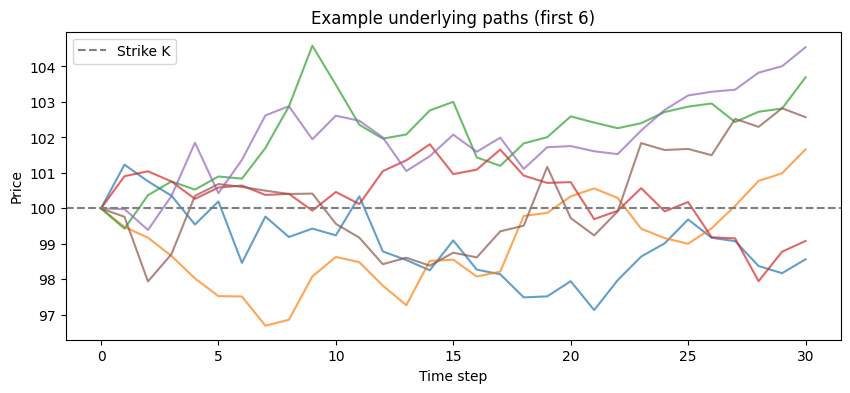

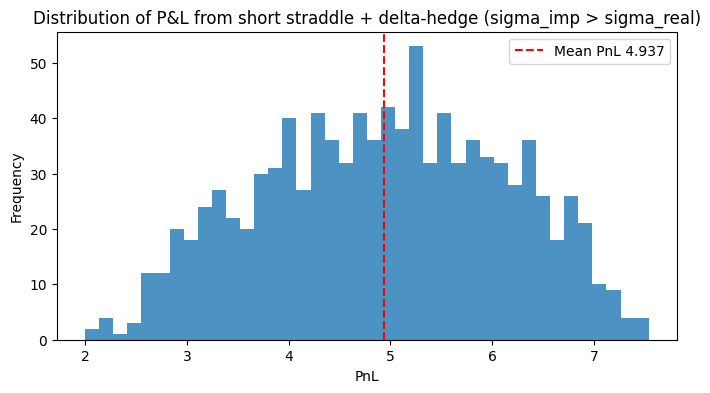

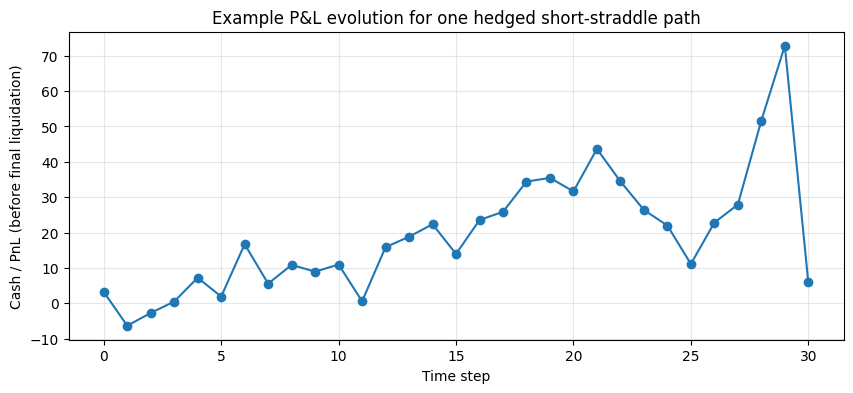

Mean PnL: 4.93685162997196
Std PnL: 1.194910410418451
Fraction profitable: 1.0


In [3]:
# Python implementation: short straddle + daily delta-hedge
# Visualizes underlying paths and shows PnL histogram / example path PnL time series.

# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Black-Scholes helpers (European)
def bs_price_delta_call(S, K, r, T, sigma):
    # T is time to maturity in years (scalar)
    if T <= 0 or sigma <= 0:
        # payoff at maturity
        return max(S-K, 0.0), (1.0 if S>K else 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta_call = norm.cdf(d1)
    return call, delta_call

def bs_price_put_from_call(call, S, K, r, T):
    # put-call parity: P = C - S + K e^{-rT}
    return call - S + K * np.exp(-r * T)

# --- Strategy parameters ---
S0 = 100.0
K = 100.0
r = 0.01                   # risk-free per annum
T_days = 30                # maturity in trading days
dt = 1/252.0               # one trading day in years
T_steps = T_days           # daily steps
T_years = T_days * dt

sigma_imp = 0.30          # implied vol used to price options and compute deltas (higher)
sigma_real = 0.12         # true vol used to simulate underlying (lower)
N_paths = 1000            # number of Monte-Carlo experiments (price paths)

np.random.seed(1)

# --- Precompute option premium (market) at t=0 using implied vol ---
C0, deltaC0 = bs_price_delta_call(S0, K, r, T_years, sigma_imp)
P0 = bs_price_put_from_call(C0, S0, K, r, T_years)
straddle_premium = C0 + P0

print(f"Initial premiums: Call {C0:.4f}, Put {P0:.4f}, Straddle total {straddle_premium:.4f}")

# --- Simulate N_paths underlying paths under sigma_real ---
Z = np.random.normal(size=(N_paths, T_steps))
S_paths = np.zeros((N_paths, T_steps+1))
S_paths[:,0] = S0
for t in range(T_steps):
    S_paths[:, t+1] = S_paths[:, t] * np.exp((0.0 - 0.5 * sigma_real**2)*dt + sigma_real * np.sqrt(dt) * Z[:, t])
    # drift zero for scenario; risk-neutral drift r could be used but hedging PnL unaffected by drift in practice

# --- Run hedging for each path ---
pnl_paths = np.zeros(N_paths)
# For storing example PnL time-series for one path
example_idx = 0
example_pnl = np.zeros(T_steps+1)

for i in range(N_paths):
    S_path = S_paths[i, :]
    # time to maturity for step t (in years)
    # We will price/delta using implied vol sigma_imp at each rebalancing with T_remain = (T_steps - t) * dt
    H_prev = 0.0
    cash = straddle_premium  # received premium initially
    # initial hedge at t=0:
    T_remain = T_years
    _, delta_call = bs_price_delta_call(S_path[0], K, r, T_remain, sigma_imp)
    # put delta = delta_call - 1
    delta_put = delta_call - 1.0
    H = delta_call + delta_put   # = 2*delta_call - 1
    # buy H shares
    cash -= H * S_path[0]
    H_prev = H

    # step forward rebalancing daily
    for t in range(1, T_steps+1):
        # accumulate interest on cash
        cash *= np.exp(r * dt)

        # compute time remaining
        T_remain = max(0.0, (T_steps - t) * dt)
        # compute new deltas using implied vol (market)
        if T_remain > 1e-12:
            _, delta_call = bs_price_delta_call(S_path[t], K, r, T_remain, sigma_imp)
            delta_put = delta_call - 1.0
            H = delta_call + delta_put
        else:
            # at maturity deltas become step functions:
            # call delta = 1 if S>K else 0; put delta = -1 if S<K else 0 => H = (1 if S>K else 0) + ( -1 if S<K else 0)
            # but we will just set H=0 since we close at maturity
            H = 0.0

        # trade dH shares at price S_path[t]
        dH = H - H_prev
        cash -= dH * S_path[t]
        H_prev = H

    # at maturity, collect liquidation flows
    # cash already accumulated; we must pay option payoff (we are short call+put)
    ST = S_path[-1]
    payoff_call = max(ST - K, 0.0)
    payoff_put = max(K - ST, 0.0)
    payoff = payoff_call + payoff_put
    # close hedge: sell H_prev shares at ST (H_prev should be 0 if we set above, but generalize)
    cash += H_prev * ST
    # pay option payoff (we are short, so we subtract payoff)
    cash -= payoff
    pnl_paths[i] = cash

    # track example path PnL evolution for the first path
    if i == example_idx:
        # recompute time series of PnL for plotting example:
        cash_ts = straddle_premium - ( (delta_call + delta_put) * S_path[0] )  # this seeds initial but not precise for TS
        # More accurate time-series below: simulate again for example to capture PnL over time
        H_prev = 0.0
        cash_ts = straddle_premium
        # initial hedge
        _, delta_call0 = bs_price_delta_call(S_path[0], K, r, T_years, sigma_imp)
        H0 = delta_call0 + (delta_call0 - 1)
        cash_ts -= H0 * S_path[0]
        H_prev = H0
        example_pnl[0] = cash_ts
        for t in range(1, T_steps+1):
            cash_ts *= np.exp(r*dt)
            T_remain = max(0.0, (T_steps - t)*dt)
            if T_remain > 1e-12:
                _, delta_call_t = bs_price_delta_call(S_path[t], K, r, T_remain, sigma_imp)
                H_t = delta_call_t + (delta_call_t - 1)
            else:
                H_t = 0.0
            dH = H_t - H_prev
            cash_ts -= dH * S_path[t]
            H_prev = H_t
            example_pnl[t] = cash_ts
        # final liquidation
        cash_ts *= np.exp(r*dt)
        ST = S_path[-1]
        H_prev = 0.0
        payoff = max(ST-K,0) + max(K-ST,0)
        cash_ts += H_prev * ST - payoff
        example_pnl[-1] = cash_ts

# --- Visualizations ---

# 1) Example underlying paths (few)
plt.figure(figsize=(10,4))
for i in range(6):
    plt.plot(S_paths[i,:], alpha=0.7)
plt.axhline(K, color='gray', linestyle='--', label='Strike K')
plt.title('Example underlying paths (first 6)')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2) Histogram of PnL from selling straddle and hedging
plt.figure(figsize=(8,4))
plt.hist(pnl_paths, bins=40, density=False, alpha=0.8)
plt.axvline(np.mean(pnl_paths), color='red', linestyle='--', label=f'Mean PnL {np.mean(pnl_paths):.3f}')
plt.title('Distribution of P&L from short straddle + delta-hedge (sigma_imp > sigma_real)')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3) Example time series PnL for one path
plt.figure(figsize=(10,4))
plt.plot(example_pnl, marker='o')
plt.title('Example P&L evolution for one hedged short-straddle path')
plt.xlabel('Time step')
plt.ylabel('Cash / PnL (before final liquidation)')
plt.grid(alpha=0.3)
plt.show()

# Summary stats
print('Mean PnL:', np.mean(pnl_paths))
print('Std PnL:', np.std(pnl_paths, ddof=1))
print('Fraction profitable:', np.mean(pnl_paths > 0.0))
